In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
# define dataset
X, _ = make_classification(n_samples=1000, n_features=10, 
                           n_informative=5, n_redundant=3, n_clusters_per_class=1, random_state=4)
df_X=pd.DataFrame(X)

### Correlation

In [6]:
corr_pearson=df_X.corr(method ='pearson')

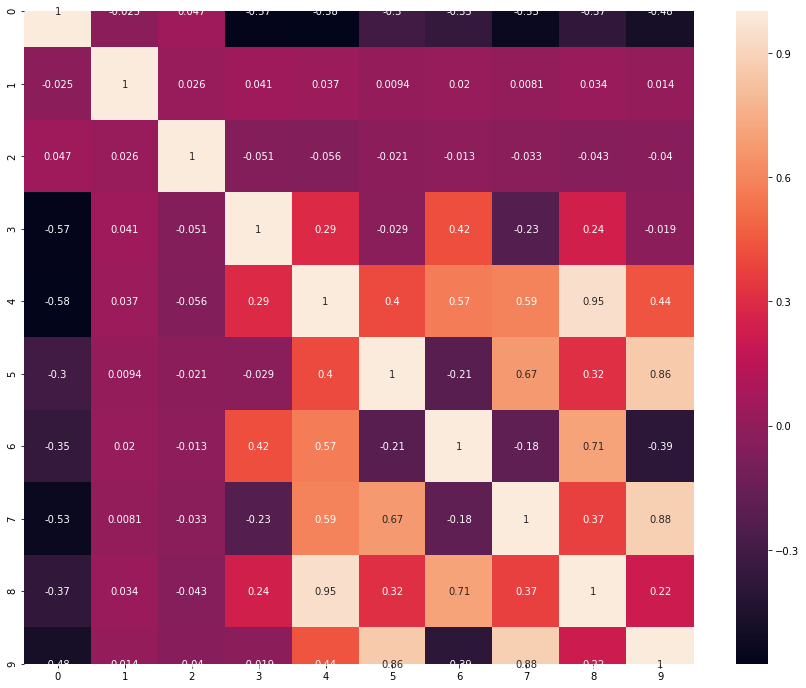

In [7]:
plt.figure(figsize=(15,12))
sns.heatmap(corr_pearson, annot=True)
plt.show()

`Feature 4` is highly correlated with `Feature 8` and `Feature 5` is highly correlated with `Feature 9`. `Feature 7` is also highly correlated with `Feature 9`. We will remove `Feature 8` and `Feature 9` from the clustering.

In [9]:
X_clust=df_X.copy()
X_clust.drop([8, 9], axis=1, inplace=True)

### Clustering

In [12]:
range_n_clusters = range(2,7)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=4)
    preds = clusterer.fit_predict(X_clust)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_clust, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.2793949246339309)
For n_clusters = 3, silhouette score is 0.30742497791419976)
For n_clusters = 4, silhouette score is 0.25794700602037574)
For n_clusters = 5, silhouette score is 0.2324123864697629)
For n_clusters = 6, silhouette score is 0.20907060462672672)


3 clusters seems to suit most.

In [13]:
KMean_t= KMeans(n_clusters=3,random_state=4)
KMean_t.fit(X_clust)
label=KMean_t.predict(X_clust)

In [14]:
df_X['cluster']=label
df_X.head()

,0,1,2,3,4,5,6,7,8,9,cluster
0,-1.650032,-0.319843,-0.784244,0.351922,1.854463,2.048136,0.385256,2.834110,1.041284,2.921819,2
1,0.030922,-1.600297,-0.333321,1.461399,-0.082091,0.064483,1.288908,-2.478437,0.307054,-1.352605,1
2,1.796847,1.085138,0.555155,-2.512640,-0.516613,1.167108,-0.151901,0.528065,0.119482,0.019636,0
3,1.510956,0.883324,-1.149847,-0.544056,-1.856359,2.254906,-3.307097,0.367940,-1.321249,2.777874,0
4,1.150509,0.071672,0.845885,0.323624,-1.623435,0.794412,-3.815378,0.297338,-1.515068,2.458164,0


## Factor Analysis

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix.

In [27]:
def compare_bartlett(df_list):
    
    for df in df_list:
        X_bartlett = eval(df) #df should be already ready for clustering
        
        chi_square_value, p_value = calculate_bartlett_sphericity(X_bartlett)
        print ("For df = {}, Bartlett's chi_square is {}, p_value is {})".format(df, chi_square_value, p_value))

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [25]:
def compare_kmo(df_list):
    
    for df in df_list: 
        
        X_KMO = eval(df) #df should be already ready for clustering
        
        kmo_all, kmo_model = calculate_kmo(X_KMO)
        print ("For df = {}, kmo is {})".format(df, kmo_model))

In [28]:
compare_bartlett(df_list=['X_clust'])

For df = X_clust, Bartlett's chi_square is 37438.7107510652, p_value is 0.0)


In [30]:
compare_kmo(df_list=['X_clust'])

For df = X_clust, kmo is 0.4764235851919048)


/Users/rliao/opt/anaconda3/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [33]:
def choose_factors(df_list):
    
    fa=FactorAnalyzer()
    for df in df_list: 
        
        X_fa = eval(df) #df should be clustering ready - all cleaning complete
        fa.fit(X_fa, 15)
        #Get Eigen values and plot them
        ev, v = fa.get_eigenvalues()
        plt.figure(figsize=(10,6))
        plt.scatter(range(1, X_fa.shape[1]+1),ev)
        plt.plot(range(1,X_fa.shape[1]+1),ev)
        plt.title(df)

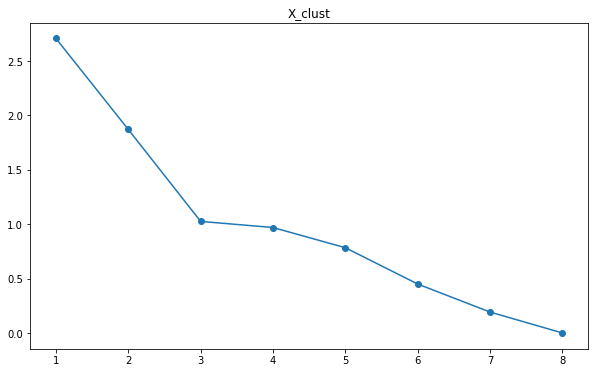

In [34]:
choose_factors(df_list=['X_clust'])

In [35]:
def get_fa_X (df, n_factor):
    
    X_fa = df
    fa = FactorAnalyzer(n_factor, rotation='varimax')
    fa.fit(X_fa)
    df_fa=pd.DataFrame(fa.loadings_)
    
    return df_fa

In [36]:
df_fa=get_fa_X(X_clust, n_factor=3)

In [38]:
df_fa.columns=['Factor1', 'Factor2', 'Factor3']
df_fa.head()

,Factor1,Factor2,Factor3
0,-0.439181,-0.636959,-0.264588
1,0.008514,0.037241,0.016603
2,-0.032431,-0.055411,-0.011628
3,-0.222625,0.971339,0.123066
4,0.560266,0.330016,0.618171
